# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
!nvidia-smi

Mon Jan 27 18:55:52 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the dataset
# This cell has to run only once.
# NO need to run every time you arrive on this notebook.

import requests
import tarfile
import os
import shutil

# Define the URL and folder paths
url = "https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz"
folder_name = "flowers"
file_name = "flower_data.tar.gz"
file_path = os.path.join(folder_name, file_name)

# Remove the folder or symbolic link if it already exists (equivalent to `rm -rf flowers`)
try:
    if os.path.islink(folder_name) or os.path.isfile(folder_name):
        os.remove(folder_name)  # Remove the symbolic link or file
    elif os.path.isdir(folder_name):
        shutil.rmtree(folder_name)  # Remove the directory
    print(f"Removed existing {folder_name} folder/file/soft link, if any.")
except FileNotFoundError:
    pass  # If the file or directory does not exist, do nothing

# Create the folder
os.makedirs(folder_name)
print(f"Created folder: {folder_name}")

# Download the file
response = requests.get(url, stream=True)

# Save the file in the 'flowers' folder
with open(file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"Downloaded {file_name} to {folder_name}")

# Extract the file in the 'flowers' folder
if file_path.endswith("tar.gz"):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=folder_name)
        print(f"Extracted {file_name} to {folder_name}")

# Clean up by removing the tar.gz file after extraction
os.remove(file_path)
print(f"Removed the downloaded tar.gz file: {file_path}")


Removed existing flowers folder/file/soft link, if any.
Created folder: flowers
Downloaded flower_data.tar.gz to flowers
Extracted flower_data.tar.gz to flowers
Removed the downloaded tar.gz file: flowers/flower_data.tar.gz


In [ ]:
# Imports here
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn import Sequential
from torchvision import models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [ ]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# TODO: Define your transforms for the training, validation, and testing sets

data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224), antialias=True),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224), antialias=True),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224), antialias=True),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}


# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': torchvision.datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': torchvision.datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': torchvision.datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=False),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False),
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
!pwd

/content/drive/MyDrive/udacityProj2


In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [ ]:
# TODO: Build and train your network

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad= False

model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# Define classifier and move model to device
input_size = model.classifier[0].in_features
output_size = 102

classifier = nn.Sequential(
    nn.Linear(input_size, 512),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 256),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(256, output_size)
)

model.classifier = classifier
model = model.to(device)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # Use criterion instead of loss to avoid confusion
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Training parameters
epochs = 10
train_losses, valid_losses = [], []

for epoch in range(epochs):
    training_loss = 0

    model.train()
    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize counters for validation accuracy and loss
    validation_correct = 0
    validation_total = 0
    valid_loss = 0.0

    # Disable gradient tracking for validation
    with torch.no_grad():
        for images, labels in dataloaders['valid']:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, prediction = torch.max(outputs.data, 1)
            validation_total += labels.size(0)
            validation_correct += (prediction == labels).sum().item()

    # Calculate validation accuracy
    validation_accuracy = validation_correct / validation_total * 100

    # Record metrics
    train_losses.append(training_loss / len(dataloaders['train']))
    valid_losses.append(valid_loss / len(dataloaders['valid']))

    # Print metrics for each epoch
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_losses[-1]:.3f}.. "
          f"Validation loss: {valid_losses[-1]:.3f}.. "
          f"Validation accuracy: {validation_accuracy:.2f}%")


Epoch 1/10.. Train loss: 1.740.. Validation loss: 1.107.. Validation accuracy: 74.94%
Epoch 2/10.. Train loss: 1.608.. Validation loss: 1.088.. Validation accuracy: 73.96%
Epoch 3/10.. Train loss: 1.481.. Validation loss: 0.993.. Validation accuracy: 77.02%
Epoch 4/10.. Train loss: 1.400.. Validation loss: 0.838.. Validation accuracy: 79.46%
Epoch 5/10.. Train loss: 1.321.. Validation loss: 0.871.. Validation accuracy: 79.10%
Epoch 6/10.. Train loss: 1.258.. Validation loss: 0.834.. Validation accuracy: 79.71%
Epoch 7/10.. Train loss: 1.193.. Validation loss: 0.742.. Validation accuracy: 82.27%
Epoch 8/10.. Train loss: 1.124.. Validation loss: 0.740.. Validation accuracy: 82.03%
Epoch 9/10.. Train loss: 1.083.. Validation loss: 0.704.. Validation accuracy: 83.62%
Epoch 10/10.. Train loss: 1.058.. Validation loss: 0.717.. Validation accuracy: 83.62%


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set

# Ensure the model is in evaluation mode
model.eval()

# Initialize counters for validation accuracy and loss
test_correct = 0
test_total = 0
test_loss = 0.0

# Disable gradient tracking for validation
with torch.no_grad():

    # Iterate through the validation dataset
    for images, labels in dataloaders['test']:

        # Move inputs and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass to get predictions
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the class index with the highest predicted probability
        _, prediction = torch.max(outputs.data, 1)

        # Update the counters for accuracy
        test_total += labels.size(0)
        test_correct += (prediction == labels).sum().item()

# Calculate validation accuracy
test_accuracy = test_correct / test_total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 80.71%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    'model_state_dict': model.state_dict(),
    'classifier': classifier,
    'epochs': epochs,
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': model.class_to_idx
}
torch.save(checkpoint, 'flower_classifier_checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    """
    Load a trained model checkpoint for inference only.
    Args: Path to the saved checkpoint file.
    Returns: Trained model ready for inference.
    """

    # Load the checkpoint
    checkpoint = torch.load(filepath, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Load the pre-trained model architecture
    model = models.vgg19(pretrained=True)  # Adjust to your model if different

    # Load the custom classifier from the checkpoint
    model.classifier = checkpoint['classifier']

    # Load the model's state_dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load the class-to-index mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Set the model to evaluation mode for inference
    model.eval()

    return model


# Example Usage
checkpoint_path = 'flower_classifier_checkpoint.pth'
model = load_checkpoint(checkpoint_path)

print("Model loaded successfully!")


<ipython-input-30-dec393edc0b6>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=torch.device('cuda' if torch.cuda.is_availab

Model loaded successfully!


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # TODO: Process a PIL image for use in a PyTorch model
    size = 224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Open the image using PIL
    img = Image.open(image_path)

    # Resize the image while preserving aspect ratio
    img.thumbnail((256, 256))

    # Calculate center crop coordinates
    width, height = img.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = left + 224
    bottom = top + 224

    # Crop the center portion of the image
    img = img.crop((left, top, right, bottom))

    # Convert PIL image to NumPy array and normalize pixel values
    img = np.array(img) / 255.0
    normalize_img = (img - mean) / std

    # Reorder dimensions for PyTorch (channels first)
    normalize_img = normalize_img.transpose((2, 0, 1))

    # Convert to a PyTorch tensor and add a batch dimension
    image_tensor = torch.tensor(normalize_img, dtype=torch.float32)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    return image_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # TODO: Implement the code to predict the class from an image file
    #img = Image.open(image_path)
    image = process_image(image_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image = image.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(image)
        #output_prob = torch.exp(output)

        # Apply the Softmax function to get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Extract topk probabilities and indices
    top_probs, top_indices = torch.topk(probabilities, topk, dim=1)

    # Convert these tensors into numpy array
    top_probs = top_probs.cpu().numpy()
    top_indices = top_indices.cpu().numpy()

    # invert the class_to_idx dictionery for mapping indices to the class labels
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}

    # Flatten the top_indices array and then iterate to get the class labels
    top_classes = [idx_to_class[i] for i in top_indices.flatten()]

    return top_probs.tolist(), top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

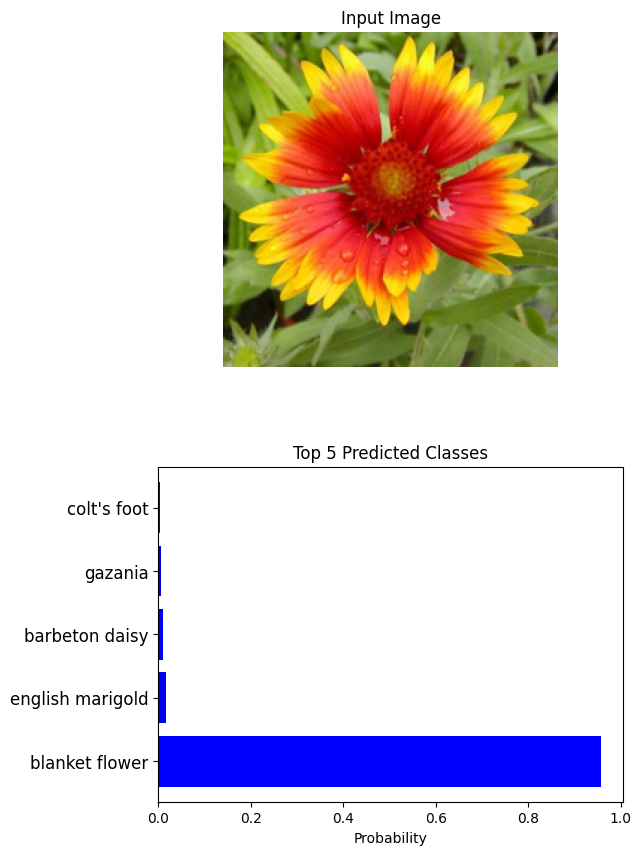

In [ ]:
# TODO: Display an image along with the top 5 classes

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

def sanity_check_func(image_path, model, topk=5):
    probs, classes = predict(image_path, model, topk=topk)
    flower_names = [cat_to_name[cls] for cls in classes]
    image = process_image(image_path)

    # Access the probabilities for the first (and only) image in the batch
    probs = probs[0]

    # Create a figure and axes with more controlled layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))  # Adjust figsize as needed
    fig.subplots_adjust(hspace=0.3)  # Add vertical spacing between subplots

    # Display the input image in the top subplot
    imshow(image.squeeze(), ax=ax1)
    ax1.set_title(f"Input Image")
    ax1.axis('off')  # Turn off axis ticks and labels for the image

    # Display the bar graph in the bottom subplot
    y_pos = np.arange(len(flower_names))  # Use np.arange for better tick control
    ax2.barh(y_pos, probs, color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names, fontsize=12)  # Adjust font size if needed
    ax2.set_xlabel('Probability')
    ax2.set_title('Top 5 Predicted Classes')

    plt.show()

# Example usage
image_path = 'flowers/test/100/image_07899.jpg'
sanity_check_func(image_path, model)
